# In the US from 1999 to 2015, were legal teams featuring greater proportions of female lawyers more or less likely to forum shop in patent law cases? 

## 1. Introduction

Brief introduction
Write a brief introduction of your project (two to four para-
graphs), the source of the data, and the important background necessary to un-
derstand your project (Keep it short. You will complete it over time). An outsider
should be able to understand what you are trying to do in this project. You should
state your data and its source, discuss your research question, and briefly mention
your findings. You should have at least five citations with one of them as your
main paper, and that paper should be the closest paper to your work. The citation
should show up in your references section as well in APA or Chicago style

### Choice of Merging Dataset

### Choice of variables

## 2. Data Cleaning/Loading

In [10]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import gc
from sklearn.linear_model import LinearRegression

# make head display all columns instead of truncting
pd.set_option('display.max_columns', None)

#### Cases data

In [13]:
# call cases data to jupyter notebook
cases = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/cases.csv")
cases = cases.sort_values("case_name", ascending=True)

# create year variable
cases["year_filed"] = cases["case_number"].str.split(":").str[1].str[:2].astype(float)
cases.loc[cases.year_filed > 17, "year_filed"] = cases["year_filed"] + 1900
cases.loc[cases.year_filed < 17, "year_filed"] = cases["year_filed"] + 2000
cases["year_filed"] = cases["year_filed"].fillna(0).astype(float)

# these observations don't have a properly formatted case number
cases = cases.drop(index=[0, 1885, 1886])

# create case order variable (indicates 1 more than the number of cases that the court received before that case in that year)
cases["case_order"] = cases["case_number"].str.split(":").str[1]
cases["case_order"] = cases["case_order"].str.split("-").str[2].astype(float)

# create variable showing the courthouse within the district that received the case
cases["courthouse"] = cases["case_number"].str.split(":").str[0]

# standardize the court name variable so that it can be merged
cases["court_name"] = cases["court_name"].str.title()

# adjust these two specific values
cases["court_name"] = cases["court_name"].str.replace("U.S. District Court (Spokane)", "Eastern District Of Washington")
cases["court_name"] = cases["court_name"].str.replace("U.S. District Court (7)", "7th Court of Appeals")

# create region variable
cases.loc[cases.court_name.str.contains("Eastern"), "court_region"] = "Eastern"
cases.loc[cases.court_name.str.contains("Southern"), "court_region"] = "Southern"
cases.loc[cases.court_name.str.contains("Western"), "court_region"] = "Western"
cases.loc[cases.court_name.str.contains("Northern"), "court_region"] = "Northern"
cases["court_region"] = cases["court_region"].fillna("None")

# create state variable
state_names = ["Alaska", "Alabama", "Arkansas", "American Samoa", "Arizona", "California", "Colorado", "Connecticut", "District Of Columbia", "Delaware", 
          "Florida", "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", 
          "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", 
          "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", 
          "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington", 
          "Wisconsin", "West Virginia", "Wyoming", "7th"]

for state in state_names:
    cases.loc[cases.court_name.str.contains(state), "court_state"] = state

# process demand variable to get rid of non-numeric values
cases["demand"] = cases["demand"].astype(str)
cases.loc[False == cases.demand.str.strip().str.isalpha(), "demand_num"] = cases["demand"]
cases["demand_num"] = cases["demand_num"].str.replace("$", "")
cases["demand_num"] = cases["demand_num"].str.replace(",", "")
cases["demand_num"] = cases["demand_num"].astype(float)

cases.loc[cases.demand.str.strip().str.isalpha(), "demand_party"] = cases["demand"]
cases["demand_party"] = cases["demand_party"].astype(str)
cases["demand_party"] = cases["demand_party"].str.replace("p", "Plaintiff")
cases.loc[cases.demand_party == "P", "demand_party"] = str("Plaintiff")
cases.loc[cases.demand_party == "y", "demand_party"] = np.nan
cases.loc[cases.demand_party == "Y", "demand_party"] = np.nan
cases.loc[cases.demand_party == "nan", "demand_party"] = np.nan

In [17]:
# call pacer_cases data to jupyter notebook
pacer_cases = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/pacer_cases.csv")
pacer_cases = pacer_cases.sort_values("case_name", ascending=True)

# prepare the pacer_cases dataset for merging

# construct year variable
pacer_cases["year_filed"] = pacer_cases["case_number"].str.split(":").str[1].str[:4]
pacer_cases.loc[False == pacer_cases["year_filed"].str.isnumeric(), "year_filed"] = pacer_cases["year_filed"].str[:2].astype(float) + 2000
pacer_cases["year_filed"] = pacer_cases["year_filed"].fillna(0).astype(int)
# NOTE: 0 indicates NaN, 56 values

# construct case order (-1 indicates the number of cases that the court received before that case in that year)
pacer_cases["case_order"] = pacer_cases["case_number"].str.split(":").str[1]
pacer_cases["case_order"] = pacer_cases["case_order"].str.split("-").str[2]
pacer_cases.loc[False == pacer_cases["case_order"].str.isnumeric(), "case_order"] = pacer_cases["case_order"].str.split(".").str[0]
pacer_cases.loc[False == pacer_cases["case_order"].str.isnumeric(), "case_order"] = pacer_cases["case_order"].str[:5]
pacer_cases["case_order"] = pacer_cases["case_order"].astype(float)

# indicates the courthouse within the district that received the case
pacer_cases["courthouse"] = pacer_cases["case_number"].str.split(":").str[0]

# standardize the court name variable so that it can be merged
pacer_cases["court_name"] = pacer_cases["court_name"].str.title()
pacer_cases["court_name"] = pacer_cases["court_name"].str.split("(").str[0]

# create region variable
pacer_cases.loc[pacer_cases.court_name.str.contains("Eastern"), "court_region"] = "Eastern"
pacer_cases.loc[pacer_cases.court_name.str.contains("Southern"), "court_region"] = "Southern"
pacer_cases.loc[pacer_cases.court_name.str.contains("Western"), "court_region"] = "Western"
pacer_cases.loc[pacer_cases.court_name.str.contains("Northern"), "court_region"] = "Northern"
pacer_cases["court_region"] = pacer_cases["court_region"].fillna("None")

# create state variable
state_names = ["Alaska", "Alabama", "Arkansas", "American Samoa", "Arizona", "California", "Colorado", "Connecticut", "District Of Columbia", "Delaware", 
          "Florida", "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", 
          "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", 
          "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", 
          "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington", 
          "Wisconsin", "West Virginia", "Wyoming", "7th"]

for state in state_names:
    pacer_cases.loc[pacer_cases.court_name.str.contains(state), "court_state"] = state
# for 76 rows, the pacer dataset doesn't have a valid case number 

In [19]:
# merge
m_cases = pd.merge(cases, pacer_cases, on=["year_filed", "case_order", "courthouse", "court_region", "court_state"], how="left")

# fill in missing values from the cases dataset using the pacer_cases dataset
m_cases["case_name_x"] = m_cases["case_name_x"].fillna(m_cases["case_name_y"])
m_cases["date_filed_x"] = m_cases["date_filed_x"].fillna(m_cases["date_filed_y"])
m_cases["date_closed_x"] = m_cases["date_closed_x"].fillna(m_cases["date_filed_y"])

# check for missing values
m_cases.isna().sum()

# group dataset by whether the year is before or after 1999
m_cases.loc[m_cases.year_filed >= 1999, "post_99"] = 1
m_cases.loc[m_cases.year_filed < 1999, "post_99"] = 0
grouped_cases = m_cases.groupby(by="post_99")

# convert dates to date format
m_cases["date_filed"] = pd.to_datetime(m_cases["date_filed_x"])
m_cases["date_closed"] = pd.to_datetime(m_cases["date_closed_x"])
m_cases["date_last_filed"] = pd.to_datetime(m_cases["date_last_filed"])

# drop superfluous variables
m_cases = m_cases.drop(columns=["date_filed_x", "date_closed_x", "case_name_y", "court_name_y", "date_closed_y", "case_number_y", 
                                "pacer_id_y", "date_filed_y"])

# make a subset of the dataset with just the cases since 1999
cases_99 = m_cases.drop(m_cases[m_cases["post_99"] != 1].index)

# list(cases_99["case_cause"].unique())

# create a binary variable indicating whether a case involves patent infringement
cases_99["case_cause"] = cases_99["case_cause"].str.lower()
cases_99["case_cause"] = cases_99["case_cause"].str.strip()
cases_99.loc[cases_99.case_cause.str.contains("infringement of patent", na=False), "patent_infringement"] = 1
cases_99.loc[cases_99.case_cause.str.contains("patent infringement", na=False), "patent_infringement"] = 1
cases_99["patent_infringement"] = cases_99["patent_infringement"].fillna(0)

#### Attorneys Data

In [34]:
# call data to jupyter notebook
attorneys = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/attorneys.csv")
gender = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/wgnd_2_0_name-gender_nocode.csv")

# collapse dataset so that there's only one entry per attorney per case
attorneys = attorneys.groupby(["case_row_id", "name"]).agg("first")
attorneys = attorneys.reset_index()

# create variable w first name
attorneys["first_name"] = attorneys["name"].str.split().str[0].str.lower().astype(str)

# merge with gender dataset, drop the dataset
attorneys = attorneys.merge(gender, left_on="first_name", right_on="name", how="left")
del [gender]
gc.collect()
gender = pd.DataFrame()

In [35]:
missing_attorneys = attorneys[attorneys["gender"].isna()]
missing_attorneys = missing_attorneys[missing_attorneys["name_x"].isna() == False]

# merge with dataset with gender names for US
gender = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/wgnd_2_0_name-gender-code_US_likely.csv")
missing_attorneys = missing_attorneys.merge(gender, left_on="first_name", right_on="name",how="left")
missing_attorneys.isna().sum()

# drop variables so you can concat the missing_attorneys dataset with the attorneys dataset
missing_attorneys["name_y"] = missing_attorneys["name"]
missing_attorneys["gender"] = missing_attorneys["gender_y"]
missing_attorneys = missing_attorneys.drop(["name", "gender_y", "gender_x"], axis= 1)

# drop missing values from the attorneys dataset, add back the missing_attorneys
attorneys = attorneys[attorneys["gender"].isna() == False]
attorneys = pd.concat([attorneys, missing_attorneys], axis = 0)

In [38]:
# label each attorney either defendent, plantiff, garnishee, mediator, witness, or other
list(attorneys["party_type"].unique())
attorneys["party_type"] = attorneys["party_type"].str.lower()

attorneys.loc[attorneys.party_type.str.contains("defendant"), "defendant"] = 1
attorneys.loc[attorneys.party_type.str.contains("respondent"), "defendant"] = 1
attorneys.loc[attorneys.party_type.str.contains("counter claimant"), "defendant"] = 1
attorneys.loc[attorneys.party_type.str.contains("dft"), "defendant"] = 1
attorneys.loc[attorneys.party_type.str.contains("plaintiff"), "plaintiff"] = 1
attorneys.loc[attorneys.party_type.str.contains("mediator"), "mediator"] = 1
attorneys.loc[attorneys.party_type.str.contains("witness"), "witness"] = 1
attorneys.loc[attorneys.party_type.str.contains("deponent"), "witness"] = 1

attorneys.loc[attorneys.defendant.isna(), "other"] = 1
attorneys.loc[attorneys.plaintiff.isna() == False, "other"] = 0
attorneys.loc[attorneys.mediator.isna() == False, "other"] = 0
attorneys.loc[attorneys.witness.isna() == False, "other"] = 0
attorneys.loc[attorneys.position.isna() == False, "other"] = 0

# create gendered variables for each attorney category
attorneys.loc[(attorneys["defendant"] == 1)&(attorneys["gender"] == "M"), "defendant_M"] = 1
attorneys.loc[(attorneys["defendant"] == 1)&(attorneys["gender"] == "F"), "defendant_F"] = 1
attorneys.loc[(attorneys["plaintiff"] == 1)&(attorneys["gender"] == "M"), "plaintiff_M"] = 1
attorneys.loc[(attorneys["plaintiff"] == 1)&(attorneys["gender"] == "F"), "plaintiff_F"] = 1
attorneys.loc[(attorneys["mediator"] == 1)&(attorneys["gender"] == "M"), "mediator_M"] = 1
attorneys.loc[(attorneys["mediator"] == 1)&(attorneys["gender"] == "F"), "mediator_F"] = 1
attorneys.loc[(attorneys["witness"] == 1)&(attorneys["gender"] == "M"), "witness_M"] = 1
attorneys.loc[(attorneys["witness"] == 1)&(attorneys["gender"] == "F"), "witness_F"] = 1
attorneys.loc[(attorneys["other"] == 1)&(attorneys["gender"] == "M"), "other_M"] = 1
attorneys.loc[(attorneys["other"] == 1)&(attorneys["gender"] == "F"), "other_F"] = 1

attorneys.loc[attorneys["gender"] == "M", "male"] = 1
attorneys.loc[attorneys["gender"] == "F", "female"] = 1
attorneys["total"] = 1

In [40]:
# aggregate to create one row per case
c_attorneys = attorneys.groupby("case_row_id").agg("sum")

c_attorneys = c_attorneys.fillna(0)
c_attorneys = c_attorneys.drop(c_attorneys.iloc[:, 0:9], axis=1)

#### Documents data

In [42]:
# call data to jupyter notebook
documents = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/documents.csv", low_memory=False)

# clean
documents["number_docs"] = 1
doc_agg = documents.groupby("case_row_id").agg("sum")

,case_number,doc_count,attachment,date_filed,long_description,doc_number,short_description,upload_date,number_docs
case_row_id,,,,,,,,,
1,0:79-cv-06704-JCP0:79-cv-06704-JCP,3,0.0,2000-08-031982-05-31,"COPY OF PAPER DOCKET SHEET (kw, Deputy Clerk) ...",37,0,0,2
3,0:83-cv-06860-JAG0:83-cv-06860-JAG0:83-cv-0686...,15,0.0,2004-02-131992-03-011990-10-161987-07-221987-0...,COPY OF PAPER DOCKET SHEET (Former Deputy Cler...,12394,0,0,5
4,0:84-cv-06456-KLR,1,0.0,2004-01-16,COPY OF PAPER DOCKET SHEET (Former Deputy Cler...,123,0,0,1
5,0:84-cv-06726-WMH0:84-cv-06726-WMH0:84-cv-0672...,10,0.0,2003-11-212003-11-211991-03-291991-03-29,COPY OF PAPER DOCKET SHEET (Former Deputy Cler...,3421,0,0,4
6,0:85-cv-06225-TES,1,0.0,2003-10-22,COPY OF PAPER DOCKET SHEET (Former Deputy Cler...,123,0,0,1
7,0:85-cv-06368-JCP,1,0.0,2003-10-10,COPY OF PAPER DOCKET SHEET (Former Deputy Cler...,81,0,0,1
8,0:85-cv-06452-WJZ,1,0.0,2003-10-09,COPY OF PAPER DOCKET SHEET (Former Deputy Cler...,178,0,0,1
9,0:85-cv-06607-JAG,1,0.0,2003-10-06,COPY OF PAPER DOCKET SHEET (Former Deputy Cler...,155,0,0,1
10,0:86-cv-06181-JWK0:86-cv-06181-JWK,3,0.0,2003-08-201986-11-25,COPY OF PAPER DOCKET SHEET (Former Deputy Cler...,17,0,0,2


In [43]:
doc_agg = doc_agg.drop(doc_agg.iloc[:, 0:8], axis=1)

#### Merging

In [46]:
# merge
df = cases_99.merge(c_attorneys, on="case_row_id", how="left")
df = df.merge(doc_agg, on="case_row_id", how="left")

## 3. Summary Statistics Tables

In [72]:
# summary statistics for 10 X variables and Y variable


#### Interpretation:

In [ ]:
# summary statistics with subgroups


#### Interpretation

## 4. Plots, Histograms, Figures

### Figure 1: Distribution of documents filed per US patent case, 1999-2015

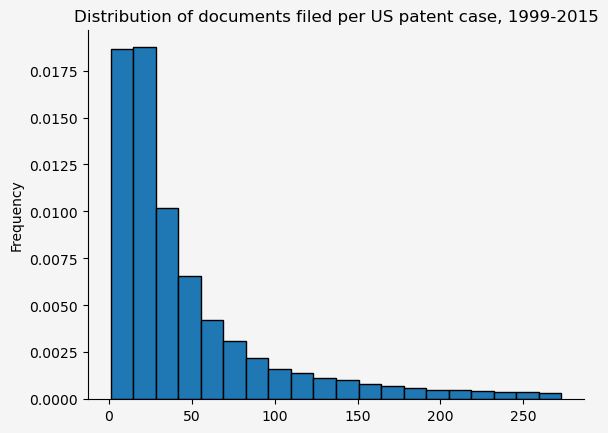

In [424]:
# histogram of the number of documents filed per case
df_hist = df[df["number_docs"] < df["number_docs"].quantile(0.95)]

fig, ax = plt.subplots()
df_hist.plot(
    kind="hist", y="number_docs",
    bins=20, legend=False, density=True, ax=ax, edgecolor = "black"
)
ax.set_facecolor((0.96, 0.96, 0.96))
fig.set_facecolor((0.96, 0.96, 0.96))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Distribution of documents filed per US patent case, 1999-2015")
plt.savefig("C:/Users/schwa/OneDrive/Desktop/School/ECO225/Results/histogram_doc_filings.png", dpi=300, format="png")

#### Interpretation:
blah

### Figure 2: Gender make-up of patent attorneys litigating in US district courts, 1999-2015

In [59]:
### bar chart of % of lawyers who are women by party type

# collapse dataset over year ranges
df_year = df.drop(df.iloc[:, 0:14], axis=1)
df_year = df_year.drop(["date_filed",	"date_closed", "date_last_filed"], axis=1)
df_year.loc[df_year["year_filed"] <= 2005, "year_range"] = "1999-2005"
df_year.loc[(2006 <= df_year["year_filed"]) & (df_year["year_filed"] <= 2010), "year_range"] = "2006-2010"
df_year.loc[df_year["year_filed"] >= 2011, "year_range"] = "2011-2015"
df_year = df_year.groupby("year_range").agg("sum")
df_year = df_year.reset_index()

# create variables with proportion of female attorneys for each party type
df_year["percent_f"] = 100 * df_year["female"] / (df_year["female"] + df_year["male"])
df_year["percent_pl_f"] = 100 * df_year["plaintiff_F"] / (df_year["plaintiff_F"] + df_year["plaintiff_M"])
df_year["percent_def_f"] = 100 * df_year["defendant_F"] / (df_year["defendant_F"] + df_year["defendant_M"])

df_year = df_year.drop(df_year.iloc[:, 1:28], axis=1)

TypeError: can only concatenate str (not "int") to str

In [57]:
Row_list =[]

# iterate over each row
for index, rows in df_year.iterrows():
    # Create list for the current row
    my_list =[rows.percent_f, rows.percent_def_f, rows.percent_pl_f]
    
    # append the list to the final list
    Row_list.append(my_list)

NameError: name 'df_year' is not defined

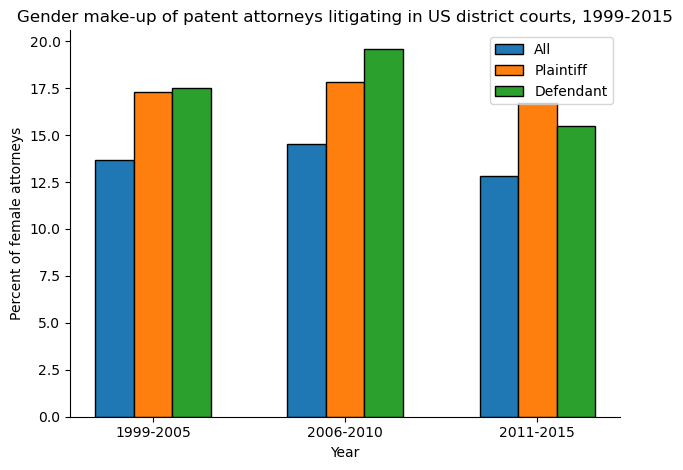

In [426]:
labels = ["All", "Plaintiff", "Defendant"]

Row_list =[]

# iterate over each row
for index, rows in df_year.iterrows():
    # Create list for the current row
    my_list =[rows.percent_f, rows.percent_def_f, rows.percent_pl_f]
    # append the list to the final list
    Row_list.append(my_list)

range_1 = Row_list[0]
range_2 = Row_list[1]
range_3 = Row_list[2]

fig, ax = plt.subplots()

index = np.arange(3)
width = 0.2

rects1 = ax.bar(
    index, range_1, width, label='All', edgecolor="black"
)

rects2 = ax.bar(
    index + width, range_2, width, label='Plaintiff', edgecolor="black"
)

rects3 = ax.bar(
    index + width*2, range_3, width, label='Defendant', edgecolor="black"
)

ax.set_xlabel('Year')
ax.set_ylabel('Percent of female attorneys')
ax.set_title('Gender make-up of patent attorneys litigating in US district courts, 1999-2015')
ax.set_xticks(index + width )
ax.set_xticklabels(('1999-2005', '2006-2010', '2011-2015'))
ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.tight_layout()
plt.savefig("C:/Users/schwa/OneDrive/Desktop/School/ECO225/Results/bar_attorney_gender.png", dpi=300, format="png")

#### Interpretation:
bla

### Figure 3: US federal courts' patent filings and the gender make-up of attorneys 

In [63]:
### relationship between the proportion of court filings and the proportion of lawyers in a court who a women

df_court = df.drop(["date_filed", "date_closed", "date_last_filed"], axis=1)
df_court.loc[df_court["year_filed"] <= 2005, "year_range"] = "1999-2005"
df_court.loc[(2006 <= df_court["year_filed"]) & (df_court["year_filed"] <= 2010), "year_range"] = "2006-2010"
df_court.loc[df_court["year_filed"] >= 2011, "year_range"] = "2011-2015"
df_court = df_court.groupby(["court_state", "court_region", "year_range"]).agg("sum")
df_court = df_court.reset_index()

# create variable showing proportion of case filings made in year range in a given court
df_court.loc[df_court["year_range"] == "1999-2005", "total_filings"] = df_court[df_court["year_range"] == "1999-2005"]["post_99"].sum(axis=0)
df_court.loc[df_court["year_range"] == "2006-2010", "total_filings"] = df_court[df_court["year_range"] == "2006-2010"]["post_99"].sum(axis=0)
df_court.loc[df_court["year_range"] == "2011-2015", "total_filings"] = df_court[df_court["year_range"] == "2011-2015"]["post_99"].sum(axis=0)
df_court["percent_filings"] = 100* df_court["post_99"] / df_court["total_filings"] 

df_court["percent_female"] = 100 * df_court["female"] / (df_court["female"] + df_court["male"])
df_court.loc[df_court["percent_female"].isna(), "percent_female"] = 0

TypeError: can only concatenate str (not "int") to str

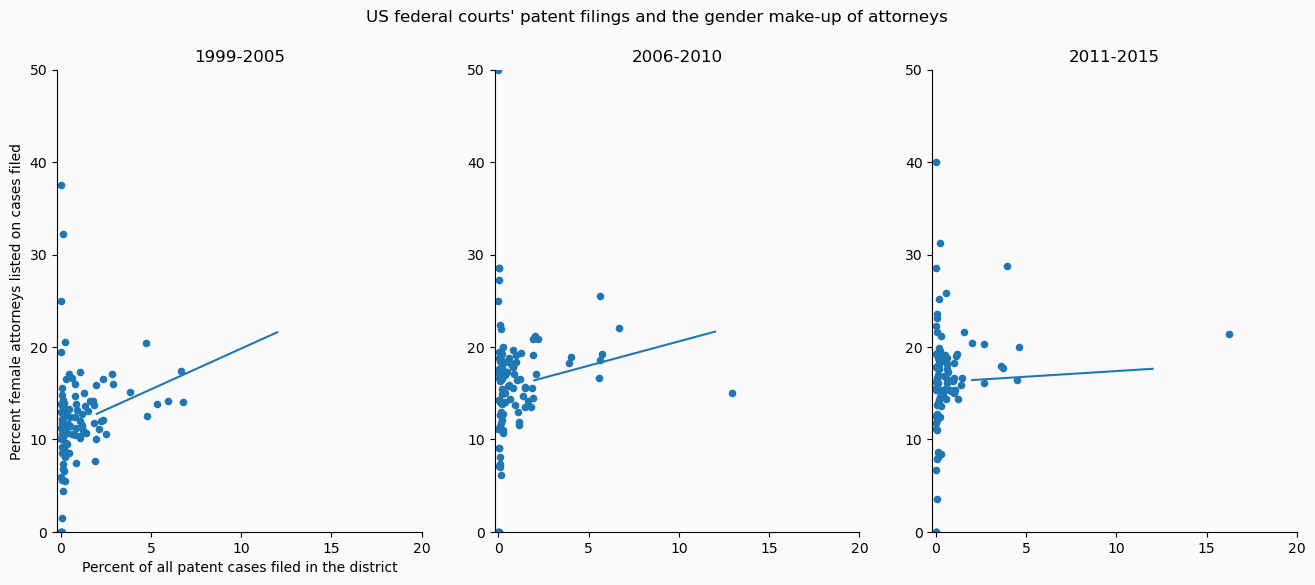

In [428]:
def single_scatter_plot(df, year, ax):
    """
    This function creates a single year's percent filings to percent female plot
    """
    # Filter data to keep only the data of interest
    _df = df_court[df_court['year_range'] == year]
    _df.plot(
        kind="scatter", x="percent_filings", y="percent_female", ax=ax
    )

    lr = LinearRegression()
    X = _df["percent_filings"].values.reshape(-1, 1)# you can feed -1 as one of the values in reshape and 
                                                # let numpy figure out that dimension
    y = _df["percent_female"].values.reshape(-1, 1) # the output is an array
    lr.fit(X, y)

    x = np.linspace(2.0, 12.0).reshape(-1, 1)
    y_pred = lr.predict(x)
    ax.plot(x, y_pred)

    return ax

# Create initial plot
fig, ax = plt.subplots(1, 3, figsize=(16, 6))

for (i, year) in enumerate(df_court.year_range.unique()):
    single_scatter_plot(df, year, ax[i])
    ax[i].set_title(str(year))

bgcolor = (250/255, 250/255, 250/255)
fig.set_facecolor(bgcolor)
for (i, _ax) in enumerate(ax):
    # Label with words
    if i == 0:
        _ax.set_xlabel("Percent of all patent cases filed in the district")
    else:
        _ax.set_xlabel("")

    # Turn off right and top axis lines
    _ax.spines['right'].set_visible(False)
    _ax.spines['top'].set_visible(False)

    # Don't use such a white background color
    _ax.set_facecolor(bgcolor)

    # Change bounds
    _ax.set_ylim((0, 50))
    _ax.set_xlim((-0.2, 20))
 
    # Change ticks
    # xticks = [10, 100, 1000, 10000]
    # _ax.set_xticks([np.log(xi) for xi in xticks])
    # _ax.set_xticklabels([str(xi) for xi in xticks])

    # yticks = list(range(5, 32, 5))
    # _ax.set_yticks([np.log(yi) for yi in yticks])
    if i == 0:
        # _ax.set_yticklabels([str(yi) for yi in yticks])
        _ax.set_ylabel("Percent female attorneys listed on cases filed")
    else:
        # _ax.set_yticklabels([])
        _ax.set_ylabel("")

ax[0].set_zorder(1)
fig.suptitle("US federal courts' patent filings and the gender make-up of attorneys")
plt.savefig("C:/Users/schwa/OneDrive/Desktop/School/ECO225/Results/scatter_filings_gender.png", dpi=300, format="png")

#### Interpretation:

In [444]:
# percent filings in top 10 courts by year

df_top = df.drop(["date_filed", "date_closed", "date_last_filed"], axis=1)
df_top = df_top.groupby(["court_state", "court_region", "year_filed"]).agg("sum")
df_top = df_top.reset_index()
df_top = df_top.drop(df_top.iloc[:, 3:22], axis=1)

# create variable showing proportion of case filings made in year range in a given court
for year in range(1999, 2016):
    df_top.loc[df_top["year_filed"] == year, "total_filings"] = df_top[df_top["year_filed"] == year]["post_99"].sum(axis=0)

# create new dataset with top 10 courts, bottom 10 courts
df_top_years = df_top[df_top["year_filed"] == 1999].nlargest(10, "post_99")
for year in range(2000, 2016):
    _df = df_top[df_top["year_filed"] == year].nlargest(10, "post_99")
    df_top_years = pd.concat([df_top_years, _df], axis = 0)
df_top_years["top10"] = 1

for year in range(1999, 2016):
    _df = df_top[df_top["year_filed"] == year].nsmallest(84, "post_99")
    df_top_years = pd.concat([df_top_years, _df], axis = 0)
df_top_years = df_top_years.fillna(0)

df_top_years = df_top_years.drop(df_top_years.iloc[:, 4:23], axis=1)
df_top_years = df_top_years.drop(df_top_years.iloc[:, 0:2], axis=1)
df_top_years["year_filed"] = df_top_years["year_filed"].astype(int)
df_top_years = df_top_years.groupby(["top10", "year_filed"]).agg({"post_99":"sum", "total_filings": "max"})

df_top_years["percent_filings"] = 100* df_top_years["post_99"] / df_top_years["total_filings"]

### Figure 4: Patent cases filed in most filed in US district circuits, 1999-2015

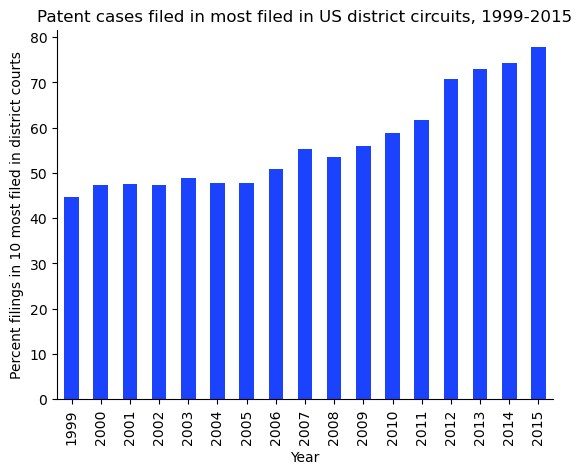

In [446]:
df_top_years = df_top_years.drop(["post_99", "total_filings"], axis=1)
df_top_years = df_top_years.reset_index(level = "top10")
df_top_years = df_top_years[df_top_years["top10"] == 1]
df_top_years = df_top_years.drop("top10", axis=1)

fig, ax = plt.subplots()

df_top_years["percent_filings"].plot(kind="bar", ax=ax, color="#1b42fc")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Year")
ax.set_ylabel("Percent filings in 10 most filed in district courts")
ax.set_title("Patent cases filed in most filed in US district circuits, 1999-2015")
plt.savefig("C:/Users/schwa/OneDrive/Desktop/School/ECO225/Results/bar_top10.png", dpi=200, format="png", bbox_inches="tight")

#### Interpretation:
d

## 5. Conclusion
This 